# Programming Exercise 2: Logistic Regression

In this exercise, you will implement logistic regression and get to see it work on data. 

## 1. Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.

In [1]:
# Import libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Read the data
data = pd.read_csv('ex2data1.txt', header=None)
X = data.iloc[:, 0:2].values
y = data.iloc[:, 2].values

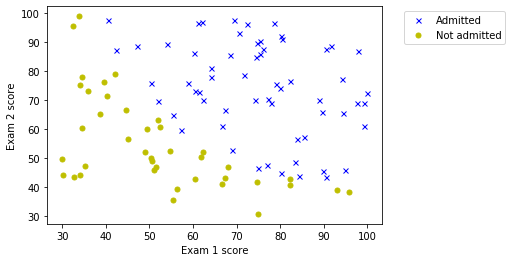

In [3]:
# Plot the data
X_pos = X[y == 1, :]
X_neg = X[y == 0, :]
plt.plot(X_pos[:, 0], X_pos[:, 1], 'bx', ms=5, label='Admitted')
plt.plot(X_neg[:, 0], X_neg[:, 1], 'yo', ms=5, label='Not admitted')
plt.ylabel('Exam 2 score')
plt.xlabel('Exam 1 score')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$
h_{\theta}(\boldsymbol{x}) = g(\boldsymbol{\theta}^T\boldsymbol{x}),
$$

where $g$ is the sigmoid function, defined as:

$$
g(z) = \frac{1}{1 + e^{-z}},
$$

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Recall that the cost function in logistic regression is:

$$
J(\boldsymbol{\theta}) = -\frac{1}{m} \left[y^T \log\left(\frac{1}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) + (1- y)^T \log\left(\frac{e^{-\boldsymbol{X}\boldsymbol{\theta}}}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right)\right],
$$

and the gradient of the cost is

$$
\frac{\partial}{\partial \boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \boldsymbol{X}^T \left[\left(\frac{1}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) - y\right].
$$

In [5]:
X = np.concatenate((np.ones((len(y), 1)), X), axis=1)
# Cost function
def J(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return -(y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h))) / m
# Gradient
def gradJ(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return X.T.dot(h - y) / m

Let's find the optimal $\boldsymbol{\theta}$ using the function `minimize` in `scipy.optimize`:

In [6]:
from scipy.optimize import minimize

In [7]:
solution = minimize(fun=J,
                    jac=gradJ,
                    x0=np.zeros(3),
                    args=(X, y)
                   )

/home/esteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [8]:
solution

      fun: 0.2034977015894438
 hess_inv: array([[ 3.31474479e+03, -2.63892205e+01, -2.70237122e+01],
       [-2.63892205e+01,  2.23869433e-01,  2.02682332e-01],
       [-2.70237122e+01,  2.02682332e-01,  2.35335117e-01]])
      jac: array([-9.52476816e-09, -9.31921315e-07, -2.82608926e-07])
  message: 'Optimization terminated successfully.'
     nfev: 31
      nit: 23
     njev: 31
   status: 0
  success: True
        x: array([-25.16133284,   0.2062317 ,   0.2014716 ])

In [9]:
# Optimal theta
theta_opt = solution.x

For a student with an Exam 1 score of 45 and an Exam 2 score of 85, the admission probability is:

In [10]:
sigmoid(theta_opt.dot(np.array([1, 45, 85])))

0.7762907240588947

Let's evaluate how well the learned model predicts on our training set:

In [11]:
# Predicted probability
prob = sigmoid(X.dot(theta_opt))
# Classification
predictions = (prob >= 0.5) * 1
# Accuracy
accuracy = (predictions == y).mean()
accuracy

0.89

Finally, let's plot the data together with the decision boundary:

In [13]:
# Generate grid
x1 = np.arange(20, 110, 0.5)
x2 = np.arange(20, 110, 0.5)
X1, X2 = np.meshgrid(x1, x2)
m, n = np.shape(X1)

In [17]:
# Generate X to evaluate the function
x1 = np.reshape(X1, (m * n, 1))
x2 = np.reshape(X2, (m * n, 1))
Xeval = np.concatenate((np.ones((m * n, 1)), x1, x2), axis=1)

In [31]:
# Generate predictions
Y = (sigmoid(Xeval.dot(theta_opt)) >= 0.5) * 1
Z = np.reshape(Y, (m, n))

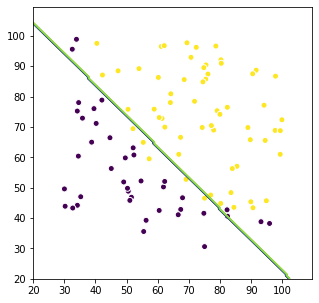

In [32]:
# Plot decision boundary
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 1], X[:, 2], c=y, edgecolors='w')
plt.contour(X1, X2, Z)
plt.show()

## 2. Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or
rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

Let's visualize the data:

In [66]:
# Read the data
data = pd.read_csv('ex2data2.txt', header=None)
X = data.iloc[:, 0:2].values
y = data.iloc[:, 2].values

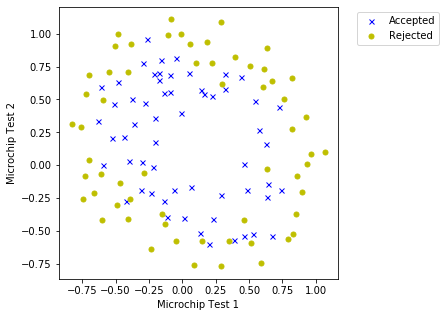

In [67]:
# Plot the data
X_pos = X[y == 1, :]
X_neg = X[y == 0, :]
plt.figure(figsize=(5, 5))
plt.plot(X_pos[:, 0], X_pos[:, 1], 'bx', ms=5, label='Accepted')
plt.plot(X_neg[:, 0], X_neg[:, 1], 'yo', ms=5, label='Rejected')
plt.ylabel('Microchip Test 2')
plt.xlabel('Microchip Test 1')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

One way to fit the data better is to create more features from each data point. The following function `map_feature`, will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

In [68]:
def map_feature(x1, x2, deg=6):
    X = np.concatenate([(x1**(i - j) * x2**j).reshape(len(x1), 1)
                        for i in range(0, deg + 1)
                        for j in range(i + 1)],
                       axis=1)
    return X

In [69]:
X = map_feature(X[:, 0], X[:, 1])

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting.

Recall that the regularized cost function in logistic regression is:

$$
J(\boldsymbol{\theta}) = -\frac{1}{m} \left[y^T \log\left(\frac{1}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) + (1- y)^T \log\left(\frac{e^{-\boldsymbol{X}\boldsymbol{\theta}}}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) + \frac{\lambda}{2}\left\lvert\left\lvert \boldsymbol{A}\boldsymbol{\theta}\right\rvert\right\rvert^2\right],
$$

and the gradient of this cost is

$$
\frac{\partial}{\partial \boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \boldsymbol{X}^T \left[\left(\frac{1}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) - y\right] + \frac{\lambda}{m}\boldsymbol{A}\boldsymbol{\theta}.
$$

In [72]:
# Cost function
def J_reg(theta, X, y, l):
    m, np1 = X.shape
    A = np.block([[np.zeros((1, 1)), np.zeros((1, np1 - 1))],
                  [np.zeros((np1 - 1, 1)), np.eye(np1 - 1)]])
    return J(theta, X, y) + l * np.linalg.norm(A.dot(theta))**2 / (2 * m)
# Gradient
def gradJ_reg(theta, X, y, l):
    m, np1 = X.shape
    A = np.block([[np.zeros((1, 1)), np.zeros((1, np1 - 1))],
                  [np.zeros((np1 - 1, 1)), np.eye(np1 - 1)]])
    return gradJ(theta, X, y) + l * A.dot(theta) / m

Let's find the optimal $\boldsymbol{\theta}$:

In [91]:
solution = minimize(fun=J_reg,
                    jac=gradJ_reg,
                    x0=np.zeros(28),
                    args=(X, y, 1)
                   )

In [92]:
# Optimal theta
theta_opt = solution.x

Finally, let's plot the data together with the decision boundary:

In [93]:
# Generate grid
x1 = np.arange(-1.2, 1.2, 0.01)
x2 = np.arange(-1.2, 1.2, 0.01)
X1, X2 = np.meshgrid(x1, x2)
m, n = np.shape(X1)

In [94]:
# Generate X to evaluate the function
x1 = np.reshape(X1, (m * n, 1))
x2 = np.reshape(X2, (m * n, 1))
Xeval = map_feature(x1, x2)

In [95]:
# Generate predictions
Y = (sigmoid(Xeval.dot(theta_opt)) >= 0.5) * 1
Z = np.reshape(Y, (m, n))

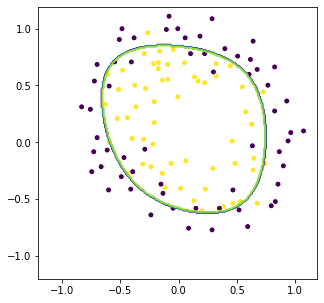

In [96]:
# Plot decision boundary
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 1], X[:, 2], c=y, edgecolors='w')
plt.contour(X1, X2, Z)
plt.show()

Accuracy on the training set:

In [97]:
# Predicted probability
prob = sigmoid(X.dot(theta_opt))
# Classification
predictions = (prob >= 0.5) * 1
# Accuracy
accuracy = (predictions == y).mean()
accuracy

0.8305084745762712

### What would happen if $\lambda=0$ (overfitting)?

In [98]:
solution = minimize(fun=J_reg,
                    jac=gradJ_reg,
                    x0=np.zeros(28),
                    args=(X, y, 0)
                   )
# Optimal theta
theta_opt = solution.x

In [99]:
# Generate predictions
Y = (sigmoid(Xeval.dot(theta_opt)) >= 0.5) * 1
Z = np.reshape(Y, (m, n))

/home/esteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


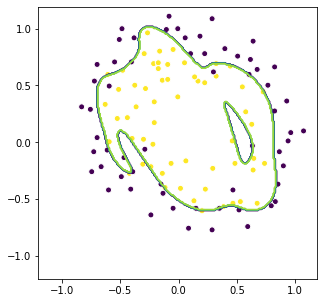

In [100]:
# Plot decision boundary
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 1], X[:, 2], c=y, edgecolors='w')
plt.contour(X1, X2, Z)
plt.show()

Accuracy on the training set:

In [101]:
# Predicted probability
prob = sigmoid(X.dot(theta_opt))
# Classification
predictions = (prob >= 0.5) * 1
# Accuracy
accuracy = (predictions == y).mean()
accuracy

0.9152542372881356

### What would happen if $\lambda=100$ (underfitting)?

In [87]:
solution = minimize(fun=J_reg,
                    jac=gradJ_reg,
                    x0=np.zeros(28),
                    args=(X, y, 100)
                   )
# Optimal theta
theta_opt = solution.x

In [88]:
# Generate predictions
Y = (sigmoid(Xeval.dot(theta_opt)) >= 0.5) * 1
Z = np.reshape(Y, (m, n))

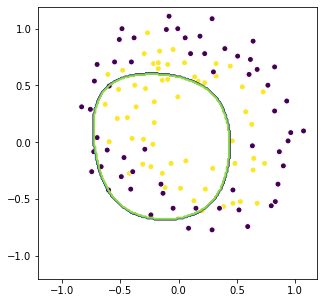

In [89]:
# Plot decision boundary
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 1], X[:, 2], c=y, edgecolors='w')
plt.contour(X1, X2, Z)
plt.show()

Accuracy on the training set:

In [102]:
# Predicted probability
prob = sigmoid(X.dot(theta_opt))
# Classification
predictions = (prob >= 0.5) * 1
# Accuracy
accuracy = (predictions == y).mean()
accuracy

0.9152542372881356

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez. Based on the content of the Machine Learning course offered through coursera by Prof. Andrew Ng.
</footer>